In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from calendar import monthrange
import os
import sys
from pathlib import Path
from datetime import datetime
from glob import glob

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE, get_era5_path, filter_by_lat_lon, interpolate_dataset_on_lat_lon, load_hdf5_file, load_imerg_raw

In [33]:
from datetime import datetime, timedelta

year = 2020
month = 4
day = 30

era5_data_dir = '/bp1store/geog-tropical/data/ERA-5/day/'
latitude_vals=np.arange(-12, 16, 1)
longitude_vals=np.arange(25, 50, 1)


fp = get_era5_path('tp', year, month, day=None, era_data_dir=era5_data_dir)
ds = xr.load_dataset(fp)

ds = filter_by_lat_lon(ds, lat_range=latitude_vals, lon_range=longitude_vals,
                       lat_var_name='latitude', lon_var_name='longitude')

# ds = ds.isel(time=0)

In [35]:
import xesmf as xe

ds_out = xr.Dataset(
        {
            'latitude': (['latitude'], [-2, -1, 0, 1, 2]),
            'longitude': (['longitude'], [33, 34, 35]),
        }
    )

# Use conservative to preserve global precipitation
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridded_ds = ds.copy()

ds['tp'].values = np.ascontiguousarray(ds['tp'].values)
regridded_ds = regridder(ds)


In [39]:
from calendar import monthrange
from tqdm import tqdm

year = 2018
all_dates = []
for month in range(1, 13):
    for day in [1, 14, 28]:
        all_dates.append((year, month, day))

hours_range = np.arange(0, 24, 2)
hour_mean_max = {}
for hour in tqdm(hours_range, total=len(hours_range)):
    hour_maxes = []
    for (year, month, day) in all_dates:
        
        ds = load_imerg_hourly(year, month, day, hour, imerg_data_dir=imerg_data_dir)

        ds = ds.sel(lon=longitude_vals, lat=latitude_vals, method='nearest')
        hour_maxes.append(ds['precipitationCal'].values.max())
    hour_mean_max[hour] = np.mean(hour_maxes)

 83%|████████▎ | 10/12 [18:52<03:46, 113.16s/it]

: 

: 

In [ ]:
hour_mean_max

{0: 12.573166,
 2: 14.2194395,
 4: 9.546983,
 6: 13.019569,
 8: 9.690663,
 10: 13.769116,
 12: 13.857353,
 14: 10.121095,
 16: 12.938535,
 18: 17.435123,
 20: 12.663201,
 22: 15.884118}

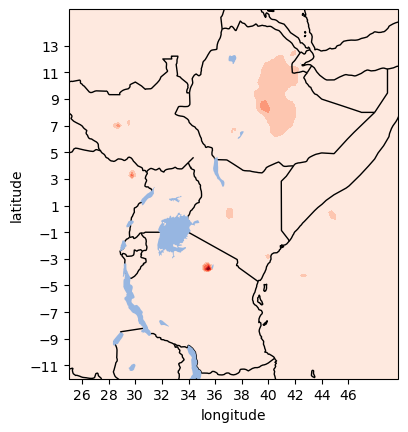

In [95]:

buffer = 5

import random

seed = None # set to None for randomness

random.seed(seed)

year = random.choice(np.arange(2017,2021,1))
month = random.choice(np.arange(1,13,1))
max_day = monthrange(year, month)[1]
day = random.choice(np.arange(1, max_day, 1))

latitude_vals=np.arange(-12, 16, 0.1)
longitude_vals=np.arange(25, 50, 0.1)

fp = get_era5_path('tp', year, month, day=None, era_data_dir=era5_data_dir)
ds = xr.load_dataset(fp)
ds = filter_by_lat_lon(ds, lat_range=latitude_vals, lon_range=longitude_vals,
                       lat_var_name='latitude', lon_var_name='longitude')

plot_precipitation(ds, 'tp', lat_var_name='latitude',
                   lon_var_name='longitude')

TypeError: interpolate_dataset_on_lat_lon() missing 1 required positional argument: 'variable'

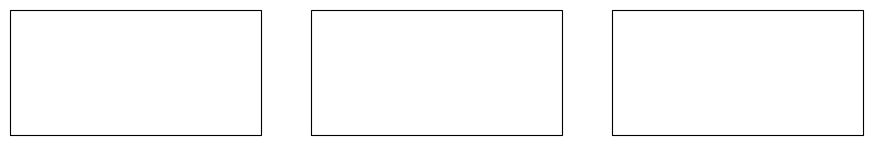

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,16))

ds_lookup = {'raw': {'ds': ds, 'name': 'Raw', 'transpose': True},
             'conservative': {'ds': interpolate_dataset_on_lat_lon(ds, 'tp',
                                                                   latitude_vals=latitude_vals, 
                                                                   longitude_vals=longitude_vals, 
                                                                   lat_var_name='latitude',
                                                                   lon_var_name='longitude',
                                                                   interp_method='conservative'),
                              'name': 'Conservative'},
             'bilinear': {'ds': interpolate_dataset_on_lat_lon(ds, 'tp',
                                                               latitude_vals=latitude_vals, 
                                                               longitude_vals=longitude_vals,
                                                               lat_var_name='latitude',
                                                               lon_var_name='longitude', 
                                                               interp_method='bilinear'),
                          'name': 'Bilinear'}}

for n, (name, attrs) in enumerate(ds_lookup.items()):

    plot_precipitation(attrs['ds'], variable='precipitationCal', ax=axs[n], transpose=attrs.get('transpose', False),
                       title=attrs['name'])
